# Random Forest Classification

## Strategy 1: don't remove anything

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', 200)

Creating a df with the disease rates for each city and their respective RISK value (1, if it belongs to a high risk cluster, and 0 otherwise).

In [2]:
cities = pd.read_csv('../../../SatScan/muncod_risk_2015_to_2017.csv', index_col=[0])

df1 = pd.read_csv('../../../TabNet/complete_rates_2015.csv', index_col=[0])
df2 = pd.read_csv('../../../TabNet/complete_rates_2016.csv', index_col=[0])
df3 = pd.read_csv('../../../TabNet/complete_rates_2017.csv', index_col=[0])
frames = [df1, df2, df3]
df = pd.concat(frames)
df = pd.merge(df, cities, left_on="MUNCOD", right_on="MUNCOD")
df = df.drop('RATE', 1)
df = df.drop('MUNCOD', 1)

In [3]:
df.shape

(9137, 16)

Selecting X (independent variables) and y (dependent binary variable).

In [4]:
X = df.iloc[:, 0:15].values
y = df.iloc[:, -1].values

Splitting the dataset into the Training set and Test set

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

Fitting Random Forest to the Training set

In [6]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Predicting the Test set results

In [7]:
y_pred = classifier.predict(X_test)

Making the Confusion Matrix

In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[2015,  376],
       [ 740, 1438]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

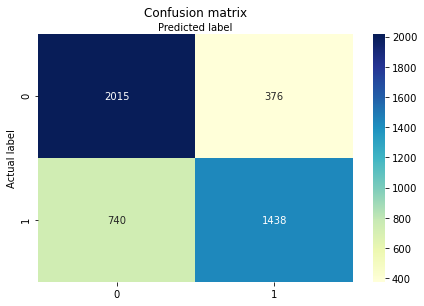

In [9]:
class_names = [0, 1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Checking Evaluation metrics

In [10]:
from sklearn import metrics
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("FBeta:",metrics.fbeta_score(y_test, y_pred, beta=2.0))

Precision: 0.7927232635060639
Recall: 0.660238751147842
FBeta: 0.6830704921147633


Plotting the ROC curve

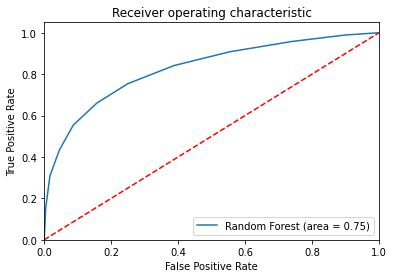

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.rc("font", size=10)
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## K-fold cross Validation

Load libraries

In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Define X and y

In [13]:
X = df.iloc[:, 0:15].values
y = df.iloc[:, -1].values

Create a pipeline that standardizes, then runs random forest

In [14]:
random = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
pipeline = make_pipeline(random)

Do k-fold cross-validation

In [15]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(pipeline, # Pipeline
                             X, # Feature matrix
                             y, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="f1", # Loss function
                             n_jobs=-1) # Use all CPU scores

(array([1., 0., 0., 3., 0., 1., 2., 1., 1., 1.]),
 array([0.67487685, 0.68260284, 0.69032883, 0.69805482, 0.70578081,
        0.7135068 , 0.72123279, 0.72895878, 0.73668477, 0.74441076,
        0.75213675]),
 <a list of 10 Patch objects>)

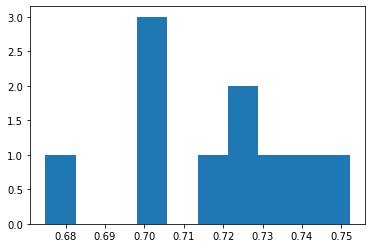

In [16]:
plt.hist(x=cv_results, bins=10)

Calculate Mean Performance Score

In [17]:
cv_results.mean()

0.7179726685716563

The mean value of f1 obtained by KFold cross validation was 0.71.

## Testing with 2018 data

Creating a df with the disease rates for each city. Now, we'll predict if the cities belong or not to the high RISK cluster (1, if it belongs to a high risk cluster, and 0 otherwise).

In [31]:
cities = pd.read_csv('../../../SatScan/muncod_risk_2018.csv', index_col=[0])

disease = ""
path = '../../../TabNet/Rates/2018/'
all_files = glob.glob(path + "*.csv")
all_diseases = cities
diseases_list = []
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("_RATE")[0]
    disease_df = pd.read_csv(path + disease + '_RATE_18.csv', sep=',', index_col=0)
    disease_df = disease_df[["RATE", "MUNCOD"]]
    disease_df.rename(columns={"RATE": disease}, inplace=True)

    all_diseases = pd.merge(disease_df, all_diseases, left_on="MUNCOD", right_on="MUNCOD", how="outer")
#df_18 = all_diseases.drop('MUNCOD', 1)
df_18 = all_diseases.drop(['TRAUMATISMO_INTRACRANIANO', 'HIV'], axis=1)
df_18

,MUNCOD,OSTEOPOROSE,MENTAL,INSUFICIENCIA_RENAL,INSUFICIENCIA_CARDIACA,HIPERTENSAO_ESSENCIAL,ESCLEROSE_MULTIPLA,EPILEPSIA,ENXAQUECA,DPOC,DORSOPATIAS,DOENCA_DE_PARKINSON,DIABETES_MILLITUS,CANCER,ASMA,ALZHEIMER,AIDS,RISK
0,110001,4.316485,25.898908,30.215393,194.241809,496.395735,NaN,51.797816,8.632969,444.597919,4.316485,NaN,181.292356,116.545086,185.608840,8.632969,4.316485,0.0
1,110037,NaN,52.922053,75.602933,68.042640,NaN,NaN,15.120587,NaN,15.120587,15.120587,NaN,90.723520,30.241173,166.326453,NaN,NaN,0.0
2,110040,NaN,4.762132,33.334921,57.145578,42.859184,NaN,9.524263,NaN,38.097052,9.524263,NaN,66.669841,66.669841,14.286395,NaN,4.762132,0.0
3,110034,13.585111,47.547888,33.962777,156.228773,142.643663,NaN,13.585111,NaN,81.510664,13.585111,NaN,251.324548,95.095775,40.755332,NaN,13.585111,0.0
4,110002,12.244744,75.352272,70.642755,108.318891,19.779971,NaN,9.419034,2.825710,61.223721,5.651420,NaN,78.177982,70.642755,54.630397,0.941903,22.605682,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5653,522090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5654,522110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5655,522120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5656,522208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [33]:
cols = df_18.columns[1:-1] # all cols, except 'RISK' 
df_18 = df_18.dropna(subset=cols, how='all')
df_18 = df_18.fillna(0)

In [34]:
df_18

,MUNCOD,OSTEOPOROSE,MENTAL,INSUFICIENCIA_RENAL,INSUFICIENCIA_CARDIACA,HIPERTENSAO_ESSENCIAL,ESCLEROSE_MULTIPLA,EPILEPSIA,ENXAQUECA,DPOC,DORSOPATIAS,DOENCA_DE_PARKINSON,DIABETES_MILLITUS,CANCER,ASMA,ALZHEIMER,AIDS,RISK
0,110001,4.316485,25.898908,30.215393,194.241809,496.395735,0.0,51.797816,8.632969,444.597919,4.316485,0.0,181.292356,116.545086,185.608840,8.632969,4.316485,0.0
1,110037,0.000000,52.922053,75.602933,68.042640,0.000000,0.0,15.120587,0.000000,15.120587,15.120587,0.0,90.723520,30.241173,166.326453,0.000000,0.000000,0.0
2,110040,0.000000,4.762132,33.334921,57.145578,42.859184,0.0,9.524263,0.000000,38.097052,9.524263,0.0,66.669841,66.669841,14.286395,0.000000,4.762132,0.0
3,110034,13.585111,47.547888,33.962777,156.228773,142.643663,0.0,13.585111,0.000000,81.510664,13.585111,0.0,251.324548,95.095775,40.755332,0.000000,13.585111,0.0
4,110002,12.244744,75.352272,70.642755,108.318891,19.779971,0.0,9.419034,2.825710,61.223721,5.651420,0.0,78.177982,70.642755,54.630397,0.941903,22.605682,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,251365,0.000000,0.000000,0.000000,0.000000,111.731844,0.0,0.000000,0.000000,37.243948,0.000000,0.0,37.243948,148.975791,111.731844,0.000000,0.000000,1.0
5566,171525,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,37.064492,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
5567,171215,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,105.708245,0.000000,0.000000,0.000000,1.0
5568,510631,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,38.850039,0.000000,0.000000,0.000000,1.0


In [36]:
X_18 = df_18.iloc[:, 1:16].values
y_18 = df_18.iloc[:, -1].values

y_18_pred = classifier.predict(X_18)

In [37]:
pd.Series(y_18_pred).value_counts()

1    3118
0    2451
dtype: int64

In [38]:
from sklearn import metrics
print("Precision:",metrics.precision_score(y_18, y_18_pred))
print("Recall:",metrics.recall_score(y_18, y_18_pred))
print("FBeta:",metrics.fbeta_score(y_18, y_18_pred, beta=2.0))

Precision: 0.673829377806286
Recall: 0.7601302460202605
FBeta: 0.7411457598419642


In [40]:
df_18_new = df_18
df_18_new["RISK"] = y_18_pred
df_18_new = df_18_new[["MUNCOD", "RISK"]]
df_18_new

,MUNCOD,RISK
0,110001,0
1,110037,0
2,110040,0
3,110034,0
4,110002,0
...,...,...
5565,251365,1
5566,171525,0
5567,171215,0
5568,510631,0


## Plotting predictions

In [27]:
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geoplot
import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

In [29]:
gd = gpd.read_file("../../../PySal/municipios/BRMUE250GC_SIR.shp")
gdf = gpd.read_file('../../../SatScan/output_spatial_analysis_2018/Suicide-SAT.col.shp')

In [ ]:
def remove_last_digit(x):
    return np.floor(x.astype(int) / 10).astype(int)

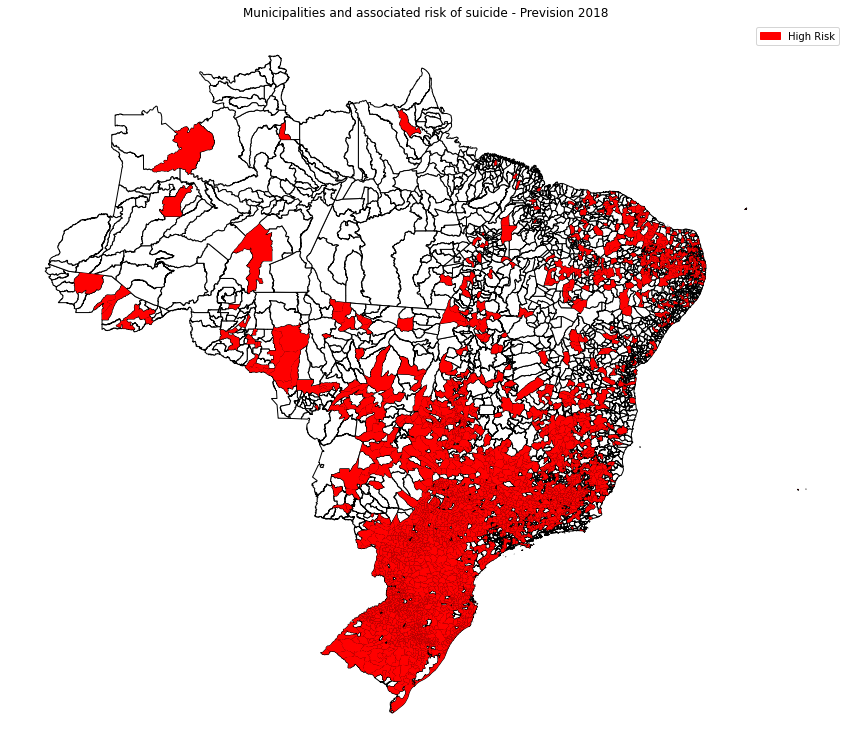

In [46]:
fig, ax = plt.subplots(figsize=(15,15))
gd.plot(ax=ax, color="white", edgecolor='black')
mun_risk_ids = df_18_new[df_18_new['RISK'] == 1]['MUNCOD'].astype(int).tolist()
gd_risk = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids)]
plot_risk = gd_risk.plot(ax=ax, color="red")

red_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[red_patch])
plt.axis('off')
plt.title("Municipalities and associated risk of suicide - Prevision 2018")
plt.savefig('municipalities_risk_2018_prediction.png')